In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize

In [17]:
# Step 1: Load and explore the dataset
iris = load_iris()
X = iris.data
y = iris.target

In [18]:
# Convert to DataFrame for better visualization
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = iris.target_names[y]

In [5]:
# Show first 5 rows of the dataset
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
# Step 2: Data Preprocessing
# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [19]:

# Step 4: Model Selection (Logistic Regression and Random Forest)
# Logistic Regression
logreg = LogisticRegression(max_iter=200)

In [20]:
# Random Forest Classifier
rf = RandomForestClassifier()


In [21]:
# Create a pipeline for logistic regression and random forest
pipeline_logreg = make_pipeline(StandardScaler(), logreg)
pipeline_rf = make_pipeline(StandardScaler(), rf)

In [22]:

# Step 5: Cross-validation for model evaluation
logreg_cv_scores = cross_val_score(pipeline_logreg, X, y, cv=5, scoring='accuracy')
rf_cv_scores = cross_val_score(pipeline_rf, X, y, cv=5, scoring='accuracy')

In [23]:
print(f"Logistic Regression Cross-Validation Accuracy: {logreg_cv_scores.mean():.4f}")
print(f"Random Forest Cross-Validation Accuracy: {rf_cv_scores.mean():.4f}")

Logistic Regression Cross-Validation Accuracy: 0.9600
Random Forest Cross-Validation Accuracy: 0.9600


In [32]:
# Step 6: Hyperparameter Tuning using GridSearchCV (for Random Forest)
param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  200]})

In [33]:
# Best hyperparameters
print(f"Best Hyperparameters for Random Forest: {grid_search_rf.best_params_}")

Best Hyperparameters for Random Forest: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}


In [34]:
# Step 7: Model Training with Best Model (Random Forest in this case)
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=10))])

In [35]:
# Step 8: Evaluation
y_pred = best_rf_model.predict(X_test)

In [36]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



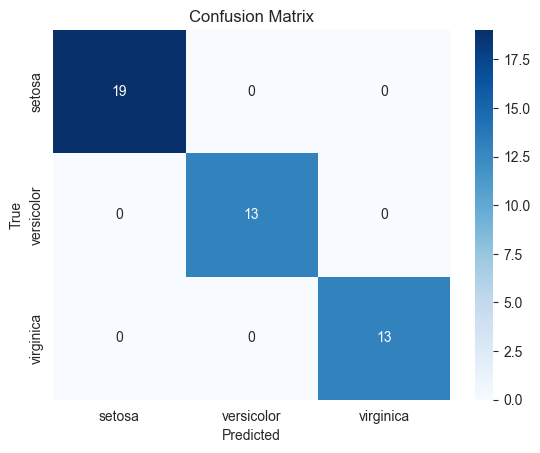

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

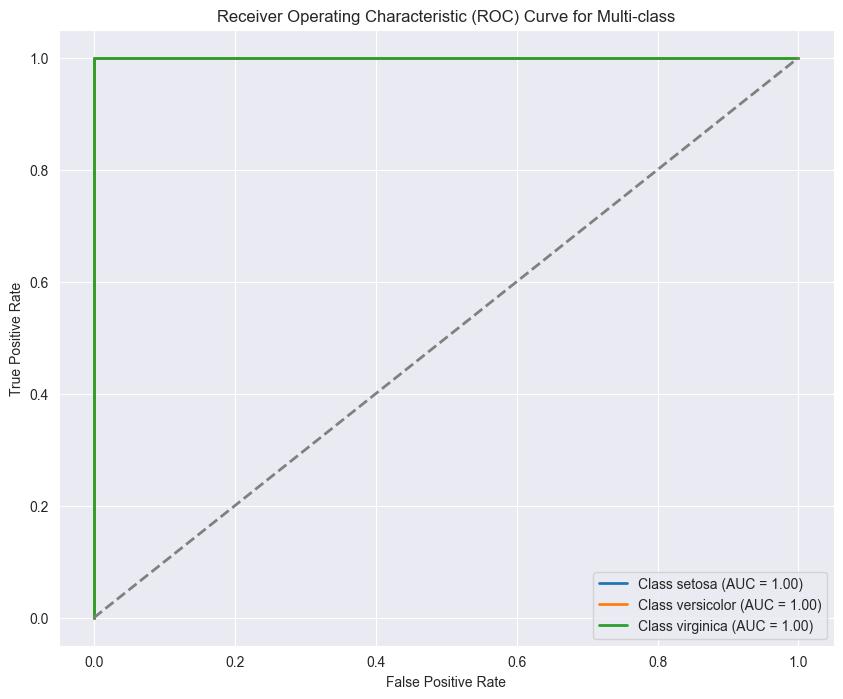

In [42]:
# Step 9: ROC Curve for Random Forest (Multi-class)
# Binarize the output labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get the probability estimates for each class
y_score = best_rf_model.predict_proba(X_test)

# Initialize the plot
plt.figure(figsize=(10, 8))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {iris.target_names[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc='lower right')
plt.show()

In [43]:
# Step 10: Prediction on new data
# Example: Predicting for a new data point (setosa flower)
new_data = np.array([[5.1, 3.5, 1.4, 0.2]])  # Example: Setosa flower measurements
new_prediction = best_rf_model.predict(new_data)
predicted_class = iris.target_names[new_prediction][0]
print(f"Predicted class for new data point: {predicted_class}")

Predicted class for new data point: virginica


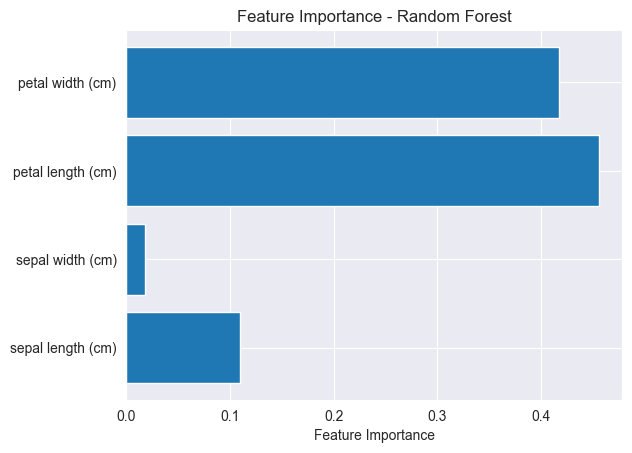

In [44]:
# Optional: Feature Importance for Random Forest
feature_importances = best_rf_model.named_steps['randomforestclassifier'].feature_importances_
features = iris.feature_names
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

In [46]:
import pickle

# Save the trained model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

# Optionally, save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
